# T-SNE Visualization of Amazon reviews with polarity based color-coding

# Loading the data

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import seaborn as sn
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading data from the saved sample SQLite
import sqlite3
import pandas as pd
con = sqlite3.connect('final_half.sqlite')
sorted_data = pd.read_sql_query("""SELECT * FROM Reviews_half""", con)
sorted_data_new = sorted_data[0:15000]
labels = sorted_data_new['Score']
print(sorted_data_new.shape)
print(labels.shape)

(15000, 11)
(15000,)


# Bag of Words (BoW)

In [3]:
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
from sklearn.manifold import TSNE

In [4]:
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(sorted_data_new['Text'].values)
standardized_data = StandardScaler(with_mean=False).fit_transform(final_counts)

In [5]:
svd = TruncatedSVD(n_components=500, n_iter=7, random_state=0)
dense_array = svd.fit_transform(standardized_data)
print(dense_array.shape)

(15000, 500)


In [6]:
model = TSNE(n_components=2,perplexity=30.0, random_state = 0)
tsne_data = model.fit_transform(dense_array)
tsne_data = np.vstack((tsne_data.T,labels)).T

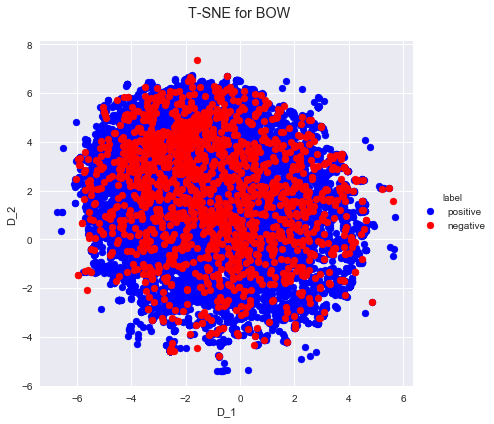

In [10]:
tsne_df = pd.DataFrame(data=tsne_data,columns = ("D_1","D_2","label"))
# # Plotting the result of tsne
colors = dict(positive="blue", negative="red")
g = sns.FacetGrid(tsne_df, hue="label", size=6,palette=colors,hue_order=["positive", "negative"]).map(plt.scatter, "D_1", "D_2").add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle('T-SNE for BOW')
plt.show()

In [11]:
model = TSNE(n_components=2, perplexity=50.0,random_state = 0)
tsne_data = model.fit_transform(dense_array)
tsne_data = np.vstack((tsne_data.T,labels)).T

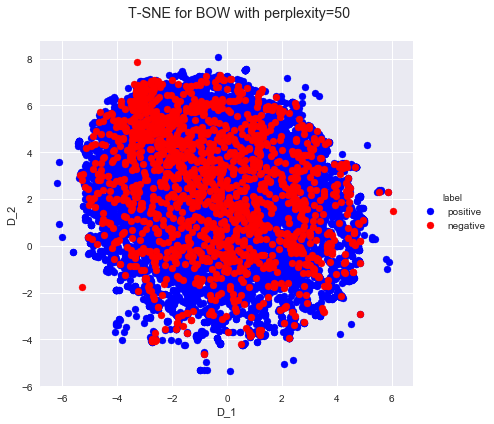

In [12]:
tsne_df = pd.DataFrame(data=tsne_data,columns = ("D_1","D_2","label"))
# # Plotting the result of tsne
colors = dict(positive="blue", negative="red")
g = sns.FacetGrid(tsne_df, hue="label", size=6,palette=colors,hue_order=["positive", "negative"]).map(plt.scatter, "D_1", "D_2").add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle('T-SNE for BOW with perplexity=50')
plt.show()

# TF-IDF

In [13]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(sorted_data_new['Text'].values)
standardized_data_tfidf = StandardScaler(with_mean=False).fit_transform(final_tf_idf)

In [14]:
svd = TruncatedSVD(n_components=500, n_iter=7, random_state=0)
dense_array_tfidf = svd.fit_transform(standardized_data_tfidf)
print(dense_array_tfidf.shape)

(15000, 500)


In [15]:
model = TSNE(n_components=2, random_state = 0)
tsne_data = model.fit_transform(dense_array_tfidf)
tsne_data = np.vstack((tsne_data.T,labels)).T

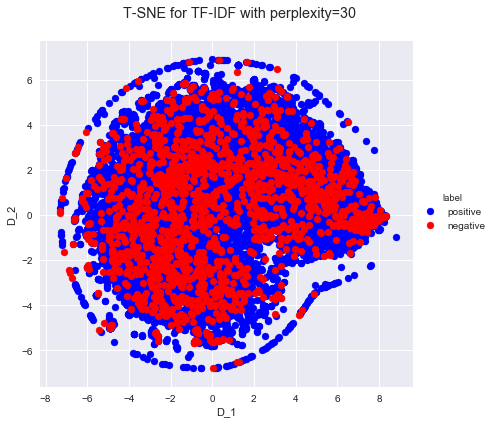

In [16]:
tsne_df = pd.DataFrame(data=tsne_data,columns = ("D_1","D_2","label"))
# # Plotting the result of tsne
colors = dict(positive="blue", negative="red")
g= sns.FacetGrid(tsne_df, hue="label", size=6,palette=colors,hue_order=["positive", "negative"]).map(plt.scatter, "D_1", "D_2").add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle('T-SNE for TF-IDF with perplexity=30')
plt.show()

In [17]:
model = TSNE(n_components=2, perplexity=50.0,random_state = 0)
tsne_data = model.fit_transform(dense_array_tfidf)
tsne_data = np.vstack((tsne_data.T,labels)).T

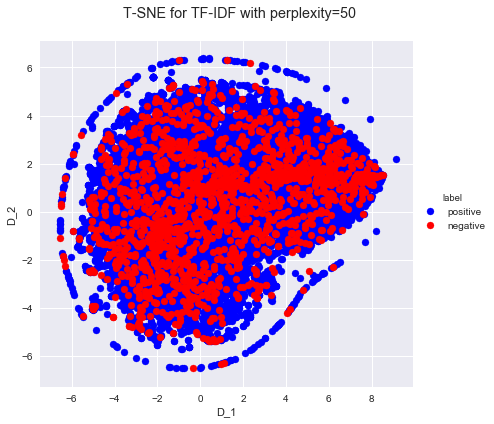

In [18]:
tsne_df = pd.DataFrame(data=tsne_data,columns = ("D_1","D_2","label"))
# # Plotting the result of tsne
colors = dict(positive="blue", negative="red")
g= sns.FacetGrid(tsne_df, hue="label", size=6,palette=colors,hue_order=["positive", "negative"]).map(plt.scatter, "D_1", "D_2").add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle('T-SNE for TF-IDF with perplexity=50')
plt.show()

# W2V

In [19]:
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary = True)
print(model)

In [20]:
model.wv.similarity('woman', 'man')

0.76640123

In [21]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [22]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in sorted_data_new['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
print(len(list_of_sent))

15000


In [23]:
print(sorted_data_new['Text'].values[0])
print(list_of_sent[0])

Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.
['beetlejuice', 'is', 'a', 'well', 'written', 'movie', 'everything', 'about', 'it', 'is', 'excellent', 'from', 'the', 'acting', 'to', 'the', 'special', 'effects', 'you', 'will', 'be', 'delighted', 'you', 'chose', 'to', 'view', 'this', 'movie']


In [48]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
type(w2v_model)

gensim.models.word2vec.Word2Vec

In [49]:
print(w2v_model.wv['well'])

[-0.3385092   0.37618127  1.88977337 -0.58881313  0.47100899 -2.53519702
 -1.13963842 -0.12824003  0.23771021  0.84235549  0.66447479 -0.0314605
  0.80564272  0.43458146  0.56102073 -1.12594211  1.35162663  0.32805339
 -0.80278045  0.87509787 -1.51345944 -1.13867545 -0.91605288  1.08563912
 -0.91399348 -0.46984008  2.06952929 -0.02879347 -0.17645206 -1.25948131
 -0.32474855 -0.55575466  0.80377465 -4.71562576  0.65567958  0.02116102
 -0.41195998  0.83852619 -0.96954292  1.74624598  1.10297143  0.21412583
 -1.61752546  1.09642434 -0.99030107  0.76973736  0.66844612  0.7028687
  0.20688297 -2.03269124]


In [50]:
words = list(w2v_model.wv.vocab)
print(len(words))

7493


# Average W2V

In [26]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

15000
50


In [45]:
model_w2v_avg = TSNE(n_components=2, random_state = 0)
tsne_data_w2v = model_w2v_avg.fit_transform(sent_vectors)
tsne_data_w2v = np.vstack((tsne_data_w2v.T,labels)).T

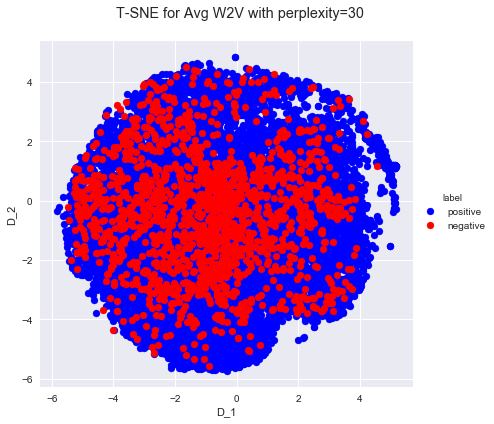

In [62]:
tsne_df_w2v = pd.DataFrame(data=tsne_data_w2v,columns = ("D_1","D_2","label"))
# # Plotting the result of tsne
colors = dict(positive="blue", negative="red")
g = sns.FacetGrid(tsne_df_w2v, hue="label", size=6,palette=colors,hue_order=["positive", "negative"]).map(plt.scatter, "D_1", "D_2").add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle('T-SNE for Avg W2V with perplexity=30')
plt.show()

In [30]:
w2v_model_1 = TSNE(n_components=2,perplexity=50.0, random_state = 0)
tsne_data_w2v_1 = w2v_model_1.fit_transform(sent_vectors)
tsne_data_w2v_1 = np.vstack((tsne_data_w2v_1.T,labels)).T

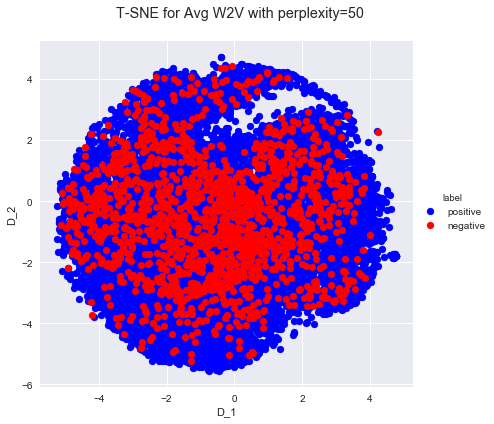

In [63]:
tsne_df_w2v_1 = pd.DataFrame(data=tsne_data_w2v_1,columns = ("D_1","D_2","label"))
# # Plotting the result of tsne
colors = dict(positive="blue", negative="red")
g = sns.FacetGrid(tsne_df_w2v_1, hue="label", size=6,palette=colors,hue_order=["positive", "negative"]).map(plt.scatter, "D_1", "D_2").add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle('T-SNE for Avg W2V with perplexity=50')
plt.show()

# TF-IDF-W2V

In [52]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            #print('tfidf',tfidf)
            sent_vec = sent_vec + (vec * tfidf)
            #print('sent_vec',sent_vec)
            weight_sum = weight_sum + tfidf
            #print('weight_sum',weight_sum)
        except:
            pass
        
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [64]:
model_tf_w2v = TSNE(n_components=2, random_state = 0)
tsne_data_tf_w2v = model_tf_w2v.fit_transform(tfidf_sent_vectors)
tsne_data_tf_w2v = np.vstack((tsne_data_tf_w2v.T,labels)).T

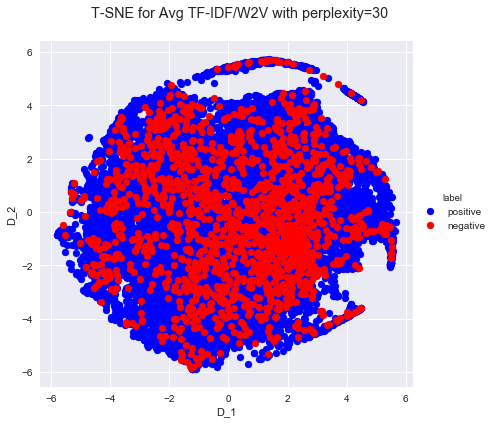

In [65]:
tsne_df_tf_w2v = pd.DataFrame(data=tsne_data_tf_w2v,columns = ("D_1","D_2","label"))
# # Plotting the result of tsne
colors = dict(positive="blue", negative="red")
g = sns.FacetGrid(tsne_df_tf_w2v, hue="label", size=6,palette=colors,hue_order=["positive", "negative"]).map(plt.scatter, "D_1", "D_2").add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle('T-SNE for Avg TF-IDF/W2V with perplexity=30')
plt.show()

In [56]:
model_tf_w2v_1 = TSNE(n_components=2,perplexity=50.0, random_state = 0)
tsne_data_tf_w2v_1 = model_tf_w2v_1.fit_transform(tfidf_sent_vectors)
tsne_data_tf_w2v_1 = np.vstack((tsne_data_tf_w2v.T,labels)).T

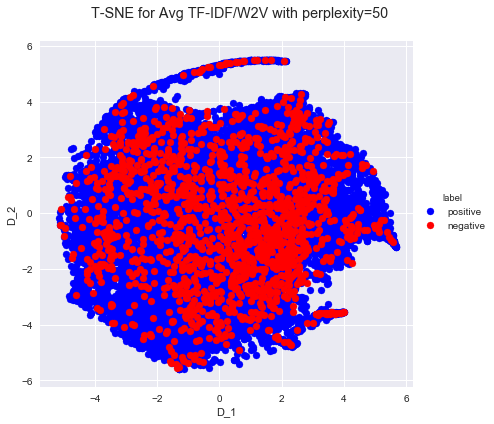

In [59]:
tsne_df = pd.DataFrame(data=tsne_data_tf_w2v_1,columns = ("D_1","D_2","label"))
# # Plotting the result of tsne
colors = dict(positive="blue", negative="red")
g = sns.FacetGrid(tsne_df, hue="label", size=6,palette=colors,hue_order=["positive", "negative"]).map(plt.scatter, "D_1", "D_2").add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle('T-SNE for Avg TF-IDF/W2V with perplexity=50')
plt.show()